In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# for interactivity
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interact_manual

# for exploratory data analysis
import sweetviz
import ppscore as pps
import imblearn

sns.set()

In [2]:
#reading the data
train= pd.read_csv('Train.csv')
test=pd.read_csv('Test.csv')

In [3]:
# lets check the shape of the train and test datasets
print("Shape of the Training Data :", train.shape)
print("Shape of the Test Data :", test.shape)

Shape of the Training Data : (54808, 14)
Shape of the Test Data : (23490, 13)


In [4]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [5]:
test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


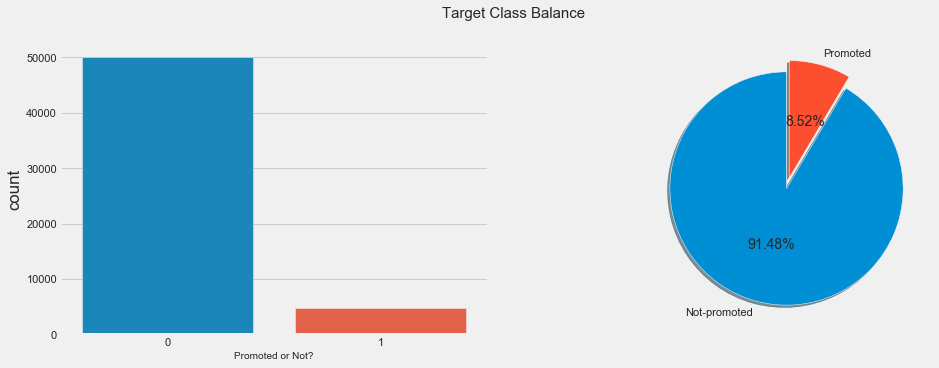

In [7]:
#target check balance

plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
sns.countplot(train['is_promoted'],)

plt.xlabel('Promoted or Not?', fontsize = 10)

plt.subplot(1, 2, 2)
train['is_promoted'].value_counts().plot(kind = 'pie', explode = [0, 0.1], autopct = '%.2f%%', startangle = 90,
                                       labels = ['Not-promoted','Promoted'], shadow = True, pctdistance = 0.5)
plt.axis('off')

plt.suptitle('Target Class Balance', fontsize = 15)
plt.show()

In [8]:
# we can see its a highly imbalance class problem
# we can easily, see that the Target Class is Highly Imbalanced, and we must balance these classes of Target Class.
# Most of the Times, when we use Machine Learning Models with Imbalanced Classes, we have very poor Results which are
# completely biased towards the class having Higher Distribution.

In [9]:
# Lets make a report using sweetviz for complete EDA
my_report = sweetviz.compare([train, "Train"], [test, "Test"], "is_promoted")
my_report.show_html("Report.html")

:FEATURES DONE:                    |█████████████████████| [100%]   00:11  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:14  -> (00:00 left)


Creating Associations graph... DONE!
Report Report.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


### Descriptive statistics

In [10]:
## lets check descriptive statistics for numerical columns
train.iloc[:,1:].describe().style.background_gradient(cmap = 'Blues')

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [11]:
# lets check descriptive statistics for categorical columns
train.describe(include = 'object')

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


In [12]:
# Lets make an interactive function to check the statistics of these numerical columns at a time

@interact
def check(column = list(train.select_dtypes('number').columns[1:8])):
    print("Maximum Value :", train[column].max())
    print("Minimum Value :", train[column].min())
    print("Mean : {0:.2f}".format(train[column].mean()))
    print("Median :", train[column].median())
    print("Standard Deviation :  {0:.2f}".format(train[column].std()))

interactive(children=(Dropdown(description='column', options=('no_of_trainings', 'age', 'previous_year_rating'…

### Missing value treatment

In [13]:
# missing values in training data set

# lets calculate the total missing values in the dataset
train_total = train.isnull().sum()

# lets calculate the percentage of missing values in the dataset
train_percent = ((train.isnull().sum()/train.shape[0])*100).round(2)

# lets calculate the total missing values in the dataset
test_total = test.isnull().sum()

# lets calculate the percentage of missing values in the dataset
test_percent = ((test.isnull().sum()/test.shape[0])*100).round(2)

# lets make a dataset consisting of total no. of missing values and percentage of missing values in the dataset
train_missing_data = pd.concat([train_total, train_percent, test_total, test_percent],
                                axis=1, 
                                keys=['Train_Total', 'Train_Percent %','Test_Total', 'Test_Percent %'],
                                sort = True)

# lets check the head
train_missing_data.style.bar(color = ['gold'])

,Train_Total,Train_Percent %,Test_Total,Test_Percent %
KPIs_met >80%,0,0.000000,0.000000,0.000000
age,0,0.000000,0.000000,0.000000
avg_training_score,0,0.000000,0.000000,0.000000
awards_won?,0,0.000000,0.000000,0.000000
department,0,0.000000,0.000000,0.000000
education,2409,4.400000,1034.000000,4.400000
employee_id,0,0.000000,0.000000,0.000000
gender,0,0.000000,0.000000,0.000000
is_promoted,0,0.000000,nan,nan
length_of_service,0,0.000000,0.000000,0.000000


In [14]:
# checking datatype of columns in the data
train.dtypes[train.isnull().any()]

education                object
previous_year_rating    float64
dtype: object

In [15]:
# lets impute the missing values in the Training Data

train['education'] = train['education'].fillna(train['education'].mode()[0])
train['previous_year_rating'] = train['previous_year_rating'].fillna(train['previous_year_rating'].mode()[0])

# lets check whether the Null values are still present or not?
print("Number of Missing Values Left in the Training Data :", train.isnull().sum().sum())

Number of Missing Values Left in the Training Data : 0


In [16]:
# lets impute the missing values in the Testing Data

test['education'] = test['education'].fillna(test['education'].mode()[0])
test['previous_year_rating'] = test['previous_year_rating'].fillna(test['previous_year_rating'].mode()[0])

# lets check whether the Null values are still present or not?
print("Number of Missing Values Left in the Testingg Data :", test.isnull().sum().sum())

Number of Missing Values Left in the Testingg Data : 0


## Univariate analysis

In [17]:
# Lets first analyze the Numberical Columns
train.select_dtypes('number').head()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,1,35,5.0,8,1,0,49,0
1,65141,1,30,5.0,4,0,0,60,0
2,7513,1,34,3.0,7,0,0,50,0
3,2542,2,39,1.0,10,0,0,50,0
4,48945,1,45,3.0,2,0,0,73,0


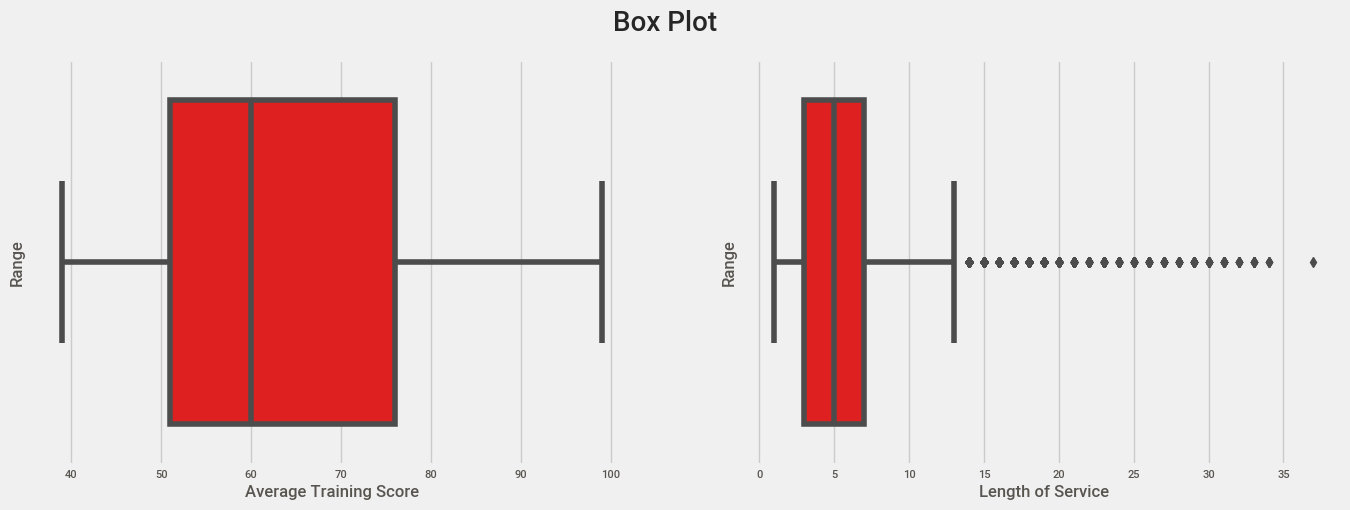

In [18]:
# lets check the boxplots for the columns where we suspect for outliers
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('fivethirtyeight')

# Box plot for average training score
plt.subplot(1, 2, 1)
sns.boxplot(train['avg_training_score'], color = 'red')
plt.xlabel('Average Training Score', fontsize = 12)
plt.ylabel('Range', fontsize = 12)

# Box plot for length of service
plt.subplot(1, 2, 2)
sns.boxplot(train['length_of_service'], color = 'red')
plt.xlabel('Length of Service', fontsize = 12)
plt.ylabel('Range', fontsize = 12)

plt.suptitle('Box Plot', fontsize = 20)
plt.show()

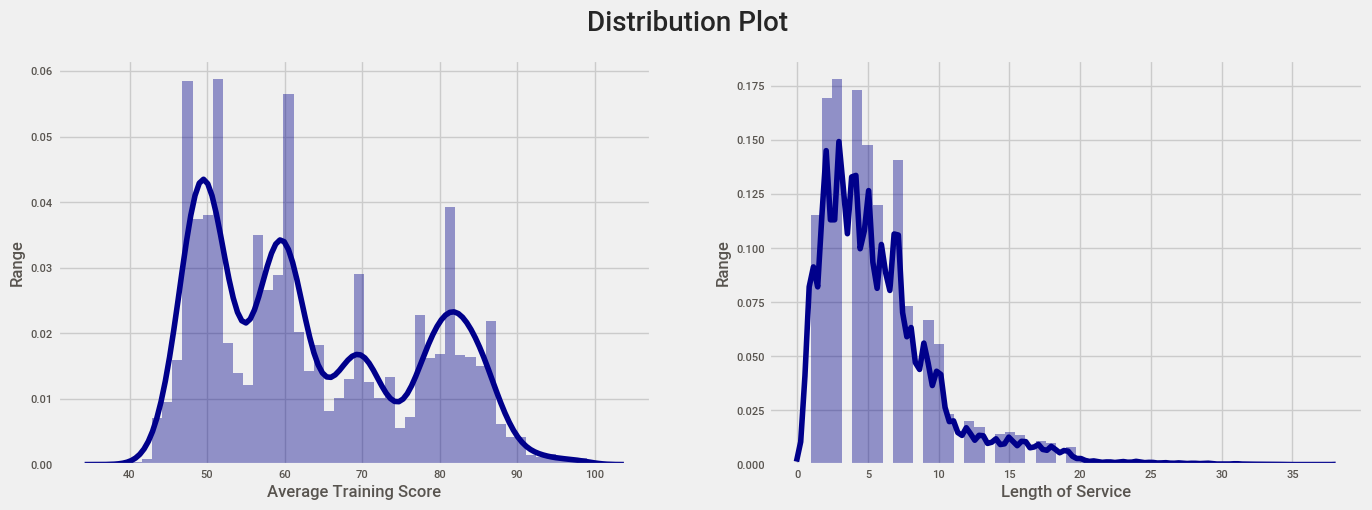

In [19]:
# Lets check the distribution for the columns for which we suspect for the outliers
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('fivethirtyeight')

# Distribution plot for Average training score
plt.subplot(1, 2, 1)
sns.distplot(train['avg_training_score'], color = 'darkblue')
plt.xlabel('Average Training Score', fontsize = 12)
plt.ylabel('Range', fontsize = 12)

# Distribution plot for Length of Service
plt.subplot(1, 2, 2)
sns.distplot(train['length_of_service'], color = 'darkblue')
plt.xlabel('Length of Service', fontsize = 12)
plt.ylabel('Range', fontsize = 12)

plt.suptitle('Distribution Plot', fontsize = 20)
plt.show()

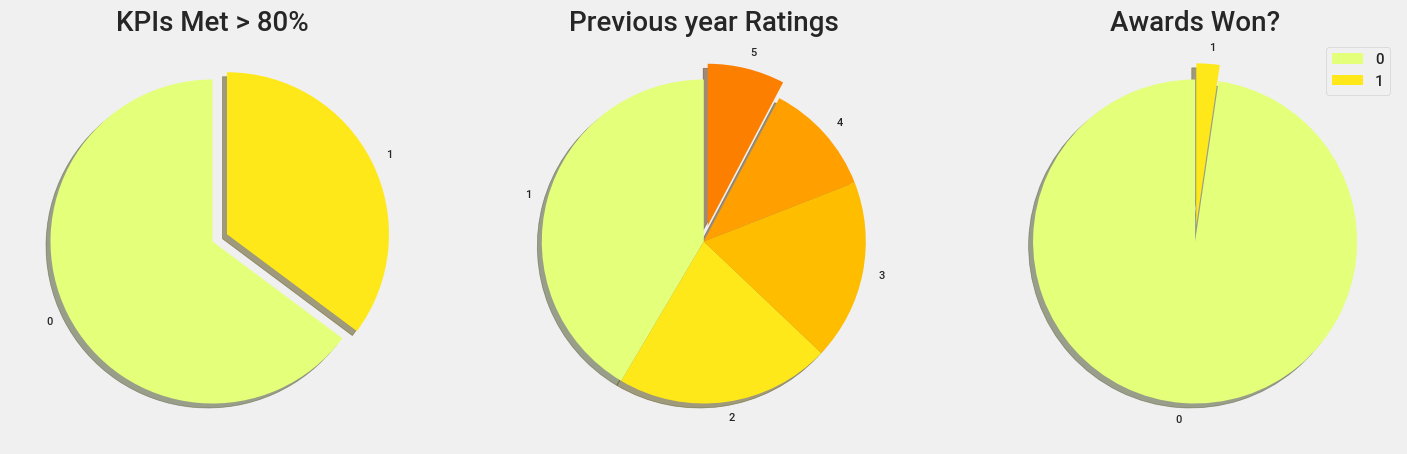

In [20]:
# lets plot pie chart for the columns where we have very few categories
plt.rcParams['figure.figsize'] = (16,5)
plt.style.use('fivethirtyeight')

# plotting a pie chart to represent share of Previous year Rating of the Employees
plt.subplot(1, 3, 1)
labels = ['0','1']
sizes = train['KPIs_met >80%'].value_counts()
colors = plt.cm.Wistia(np.linspace(0, 1, 5))
explode = [0, .1]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('KPIs Met > 80%', fontsize = 20)

# plotting a pie chart to represent share of Previous year Rating of the Employees
plt.subplot(1, 3, 2)
labels = ['1', '2', '3', '4', '5']
sizes = train['previous_year_rating'].value_counts()
colors = plt.cm.Wistia(np.linspace(0, 1, 5))
explode = [0, 0, 0, 0, 0.1]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('Previous year Ratings', fontsize = 20)

# plotting a pie chart to represent share of Previous year Rating of the Employees
plt.subplot(1, 3, 3)
labels = ['0', '1']
sizes = train['awards_won?'].value_counts()
colors = plt.cm.Wistia(np.linspace(0, 1, 5))
explode = [0,0.1]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('Awards Won?', fontsize = 20)


plt.legend()
plt.show()

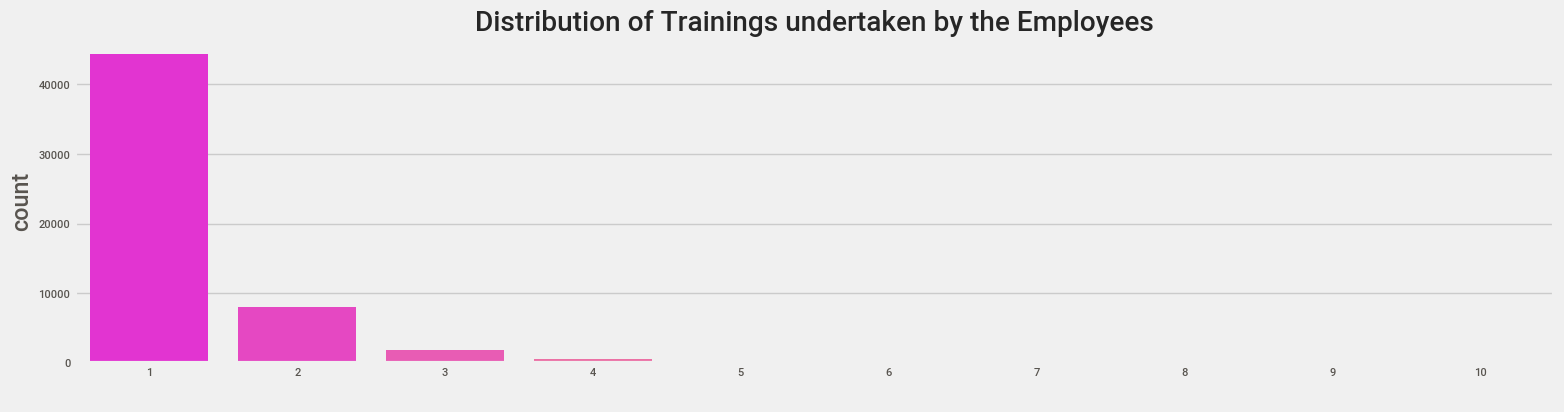

In [21]:
# lets check the distribution of trainings undertaken by the employees

plt.rcParams['figure.figsize'] = (17, 4)
sns.countplot(train['no_of_trainings'], palette = 'spring')
plt.xlabel(' ', fontsize = 14)
plt.title('Distribution of Trainings undertaken by the Employees')
plt.show()


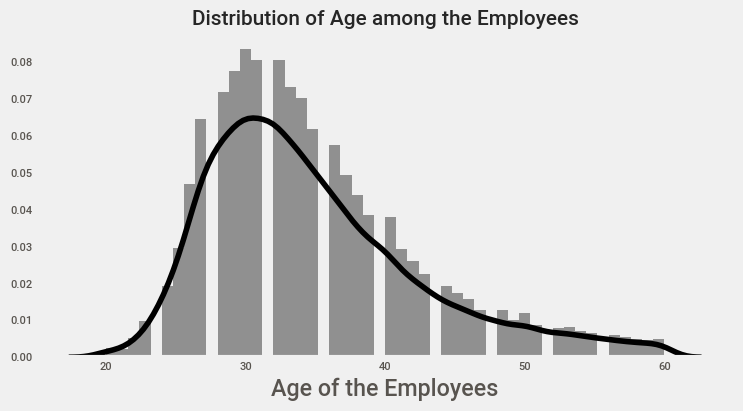

In [22]:
# lets check the Age of the Employees

plt.rcParams['figure.figsize'] = (8, 4)
sns.distplot(train['age'], color = 'black')
plt.title('Distribution of Age among the Employees', fontsize = 15)
plt.xlabel('Age of the Employees')
plt.grid()
plt.show()

In [23]:
# lets now check the columns which are categorical
train.select_dtypes('object').head()

,department,region,education,gender,recruitment_channel
0,Sales & Marketing,region_7,Master's & above,f,sourcing
1,Operations,region_22,Bachelor's,m,other
2,Sales & Marketing,region_19,Bachelor's,m,sourcing
3,Sales & Marketing,region_23,Bachelor's,m,other
4,Technology,region_26,Bachelor's,m,other


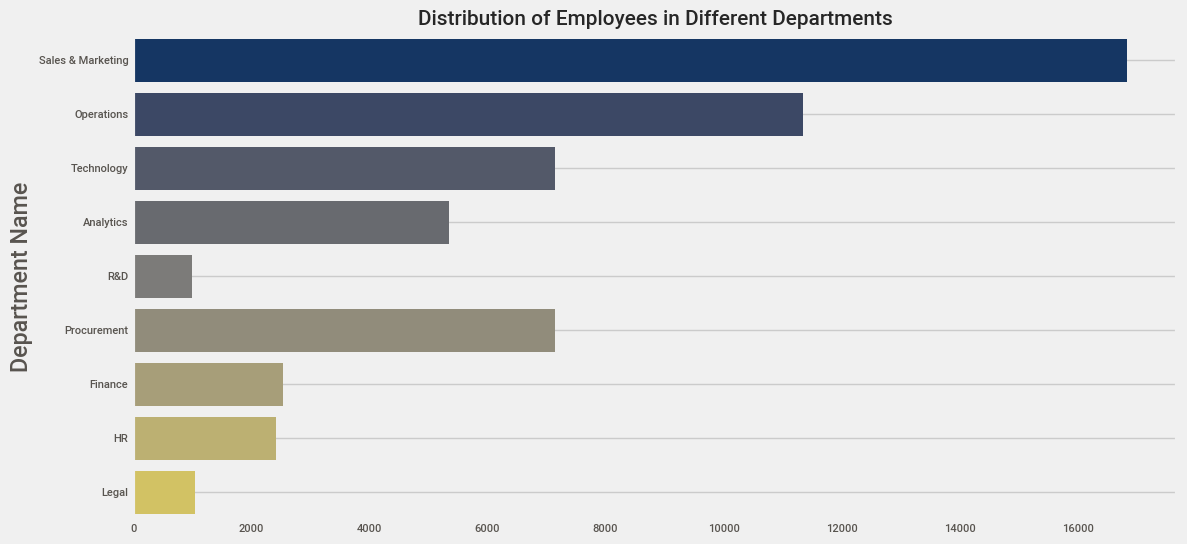

In [24]:
# lets check different Departments

plt.rcParams['figure.figsize'] = (12, 6)
sns.countplot(y = train['department'], palette = 'cividis', orient = 'v')
plt.xlabel('')
plt.ylabel('Department Name')
plt.title('Distribution of Employees in Different Departments', fontsize = 15)
plt.grid()
plt.show()

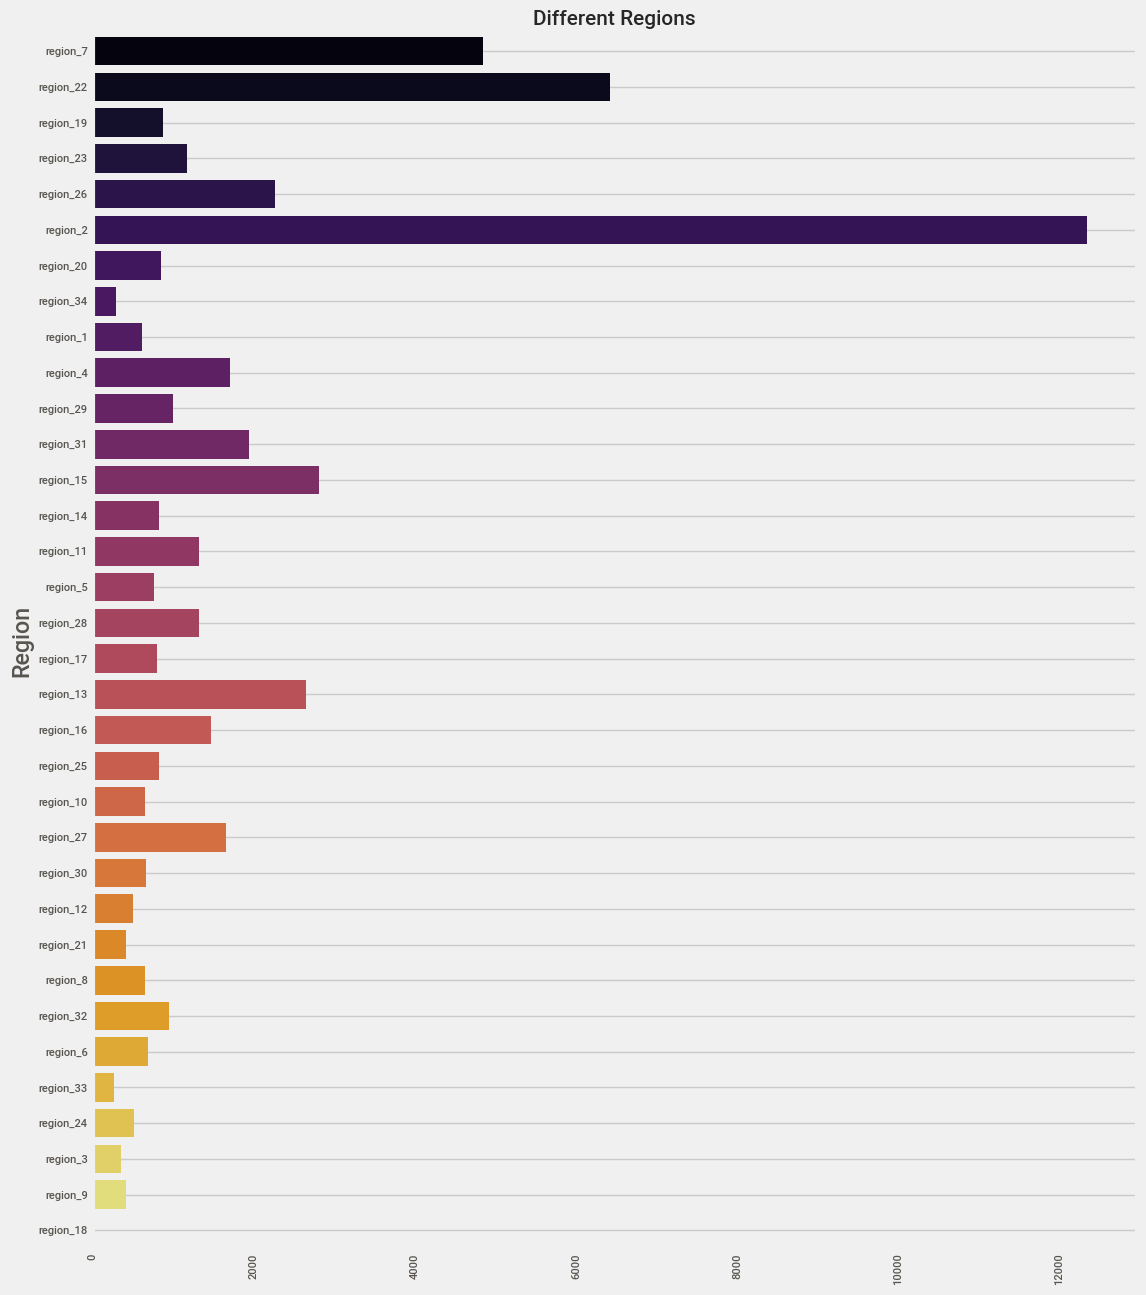

In [25]:
# lets check distribution of different Regions

plt.rcParams['figure.figsize'] = (12,15)
sns.countplot(y = train['region'], palette = 'inferno', orient = 'v')
plt.xlabel('')
plt.ylabel('Region')
plt.title('Different Regions', fontsize = 15)
plt.xticks(rotation = 90)
plt.grid()
plt.show()

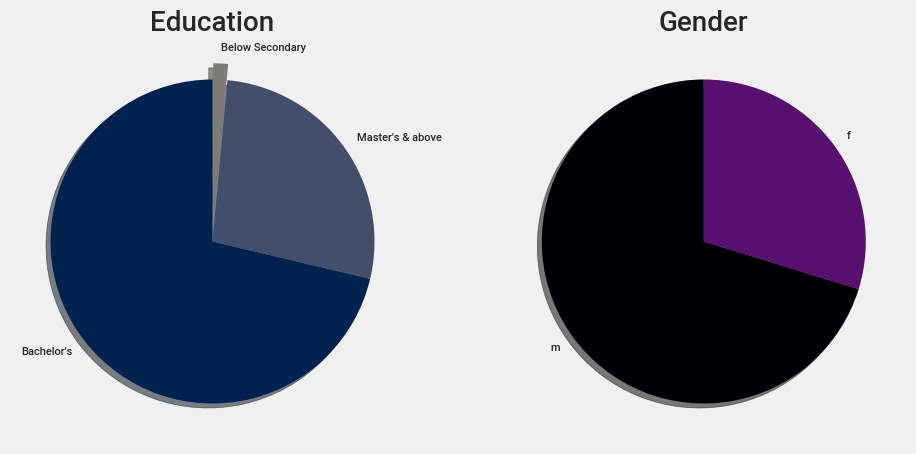

In [26]:
# lets plot pie chart for the columns where we have very few categories
plt.rcParams['figure.figsize'] = (16,5)

# plotting a pie chart to represent share of Previous year Rating of the Employees
plt.subplot(1, 3, 1)
labels = train['education'].value_counts().index
sizes = train['education'].value_counts()
colors = plt.cm.cividis(np.linspace(0, 1, 5))
explode = [0, 0, 0.1]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('Education', fontsize = 20)

# plotting a pie chart to represent share of Previous year Rating of the Employees
plt.subplot(1, 3, 2)
labels = train['gender'].value_counts().index
sizes = train['gender'].value_counts()
colors = plt.cm.inferno(np.linspace(0, 1, 5))
explode = [0, 0]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('Gender', fontsize = 20)



plt.show()

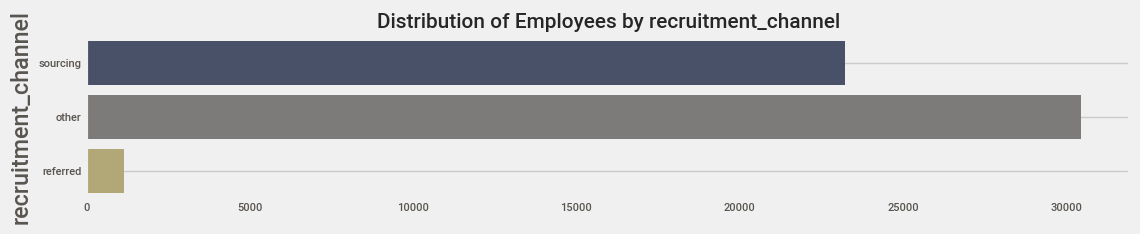

In [27]:
plt.rcParams['figure.figsize'] = (12, 2)
sns.countplot(y = train['recruitment_channel'], palette = 'cividis', orient = 'v')
plt.xlabel('')
plt.ylabel('recruitment_channel')
plt.title('Distribution of Employees by recruitment_channel', fontsize = 15)
plt.grid()
plt.show()

In [28]:
# interactive function for plotting univariate charts for categorical data

plt.rcParams['figure.figsize'] = (15, 4)
@interact_manual
def check(column = list(train.select_dtypes('object').columns),
          palette = ['cividis','copper','spring','Reds','Blues']):
    sns.countplot(train[column], palette = palette)
   
    plt.show()

interactive(children=(Dropdown(description='column', options=('department', 'region', 'education', 'gender', '…

## Bivariate Analysis

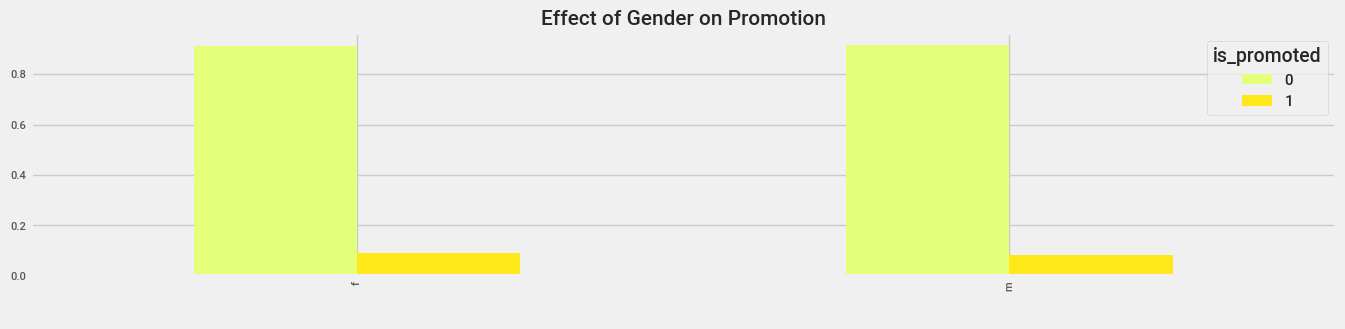

In [29]:
# Lets compare the Gender Gap in the promotion

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 3)
x = pd.crosstab(train['gender'], train['is_promoted'])
colors = plt.cm.Wistia(np.linspace(0, 1, 5))
x.div(x.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = False, color = colors)
plt.title('Effect of Gender on Promotion', fontsize = 15)
plt.xlabel(' ')
plt.show()

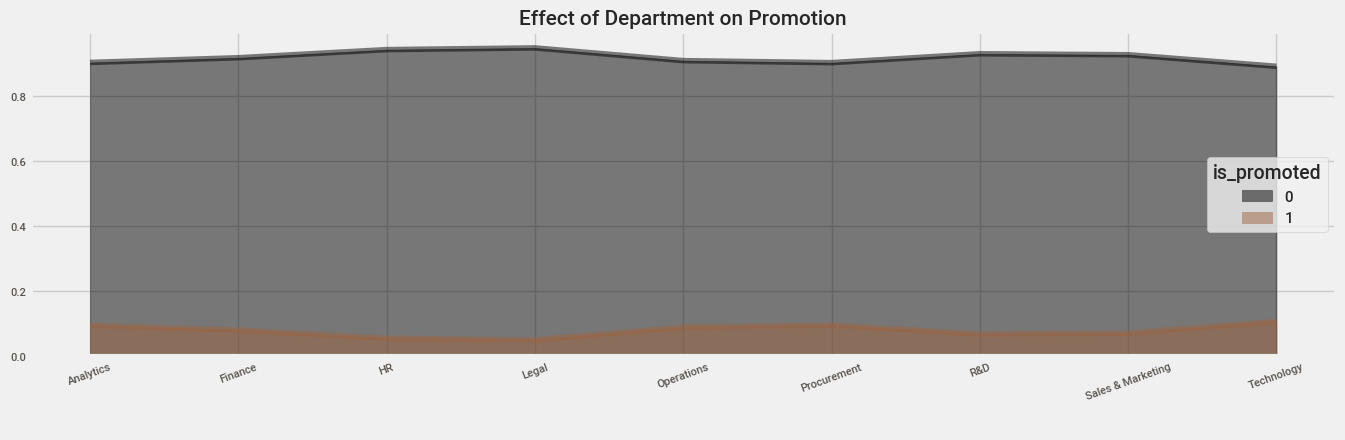

In [30]:
# lets compare the effect of different Departments and Promotion

plt.rcParams['figure.figsize'] = (15,4)
x = pd.crosstab(train['department'], train['is_promoted'])
colors = plt.cm.copper(np.linspace(0, 1, 3))
x.div(x.sum(1).astype(float), axis = 0).plot(kind = 'area', stacked = False, color = colors)
plt.title('Effect of Department on Promotion', fontsize = 15)
plt.xticks(rotation = 20)
plt.xlabel(' ')
plt.show()

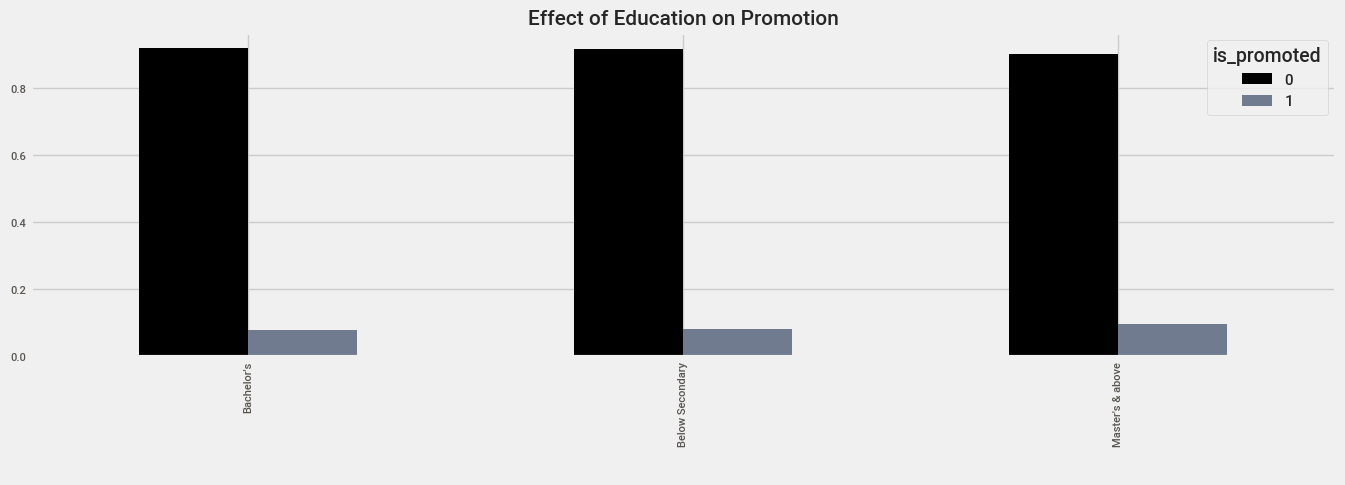

In [31]:
# lets compare the effect of Education and Promotion

plt.rcParams['figure.figsize'] = (15,4)
x = pd.crosstab(train['education'], train['is_promoted'])
colors = plt.cm.bone(np.linspace(0, 1, 3))
x.div(x.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = False, color = colors)
plt.title('Effect of Education on Promotion', fontsize = 15)
plt.xlabel(' ')
plt.show()

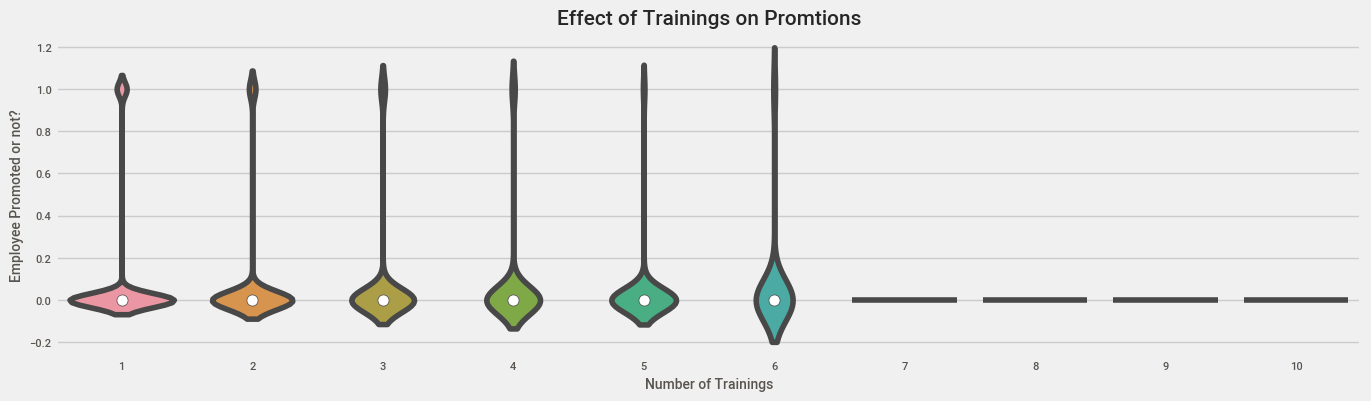

In [32]:
# checking the effect of number of trainings on promotion

plt.rcParams['figure.figsize'] = (15,4)
sns.violinplot(train['no_of_trainings'], train['is_promoted'])
plt.title('Effect of Trainings on Promtions', fontsize = 15)
plt.xlabel('Number of Trainings', fontsize = 10)
plt.ylabel('Employee Promoted or not?', fontsize = 10)
plt.show()

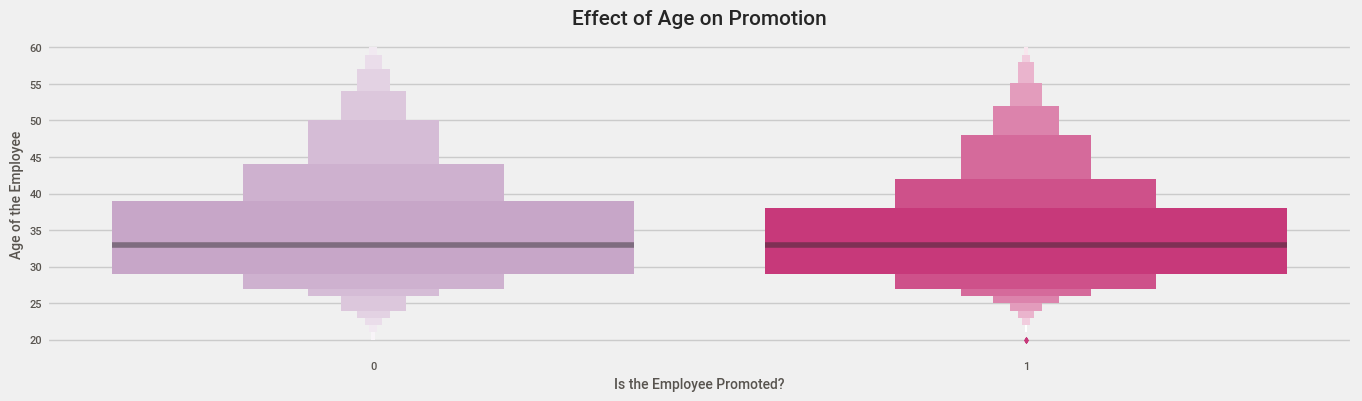

In [33]:
# Effect of Age on the Promotion

plt.rcParams['figure.figsize'] = (15,4)
sns.boxenplot(train['is_promoted'], train['age'], palette = 'PuRd')
plt.title('Effect of Age on Promotion', fontsize = 15)
plt.xlabel('Is the Employee Promoted?', fontsize = 10)
plt.ylabel('Age of the Employee', fontsize = 10)
plt.show()

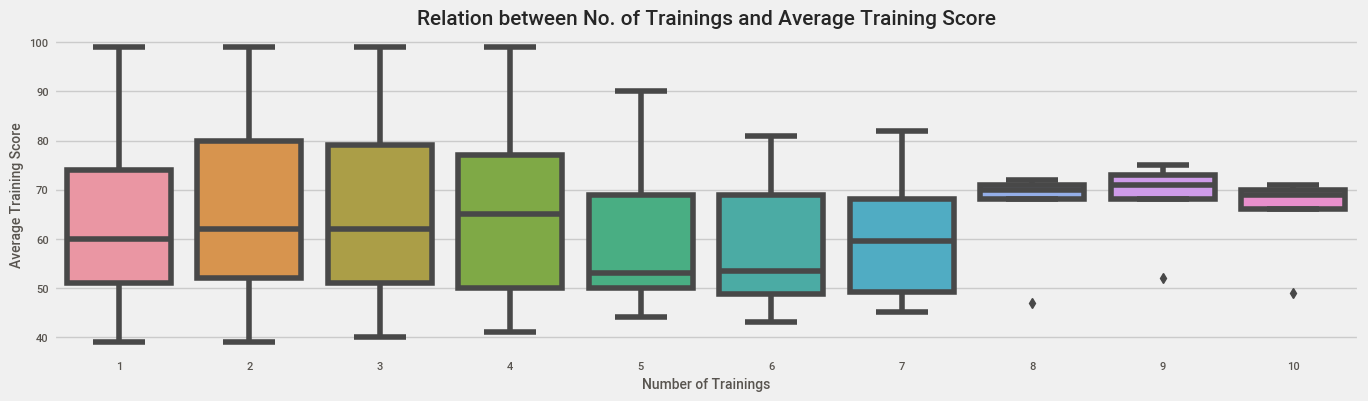

In [34]:
# lets check relation between number of trainings and average training score

plt.rcParams['figure.figsize'] = (15,4)
sns.boxplot(train['no_of_trainings'], train['avg_training_score'])
plt.title('Relation between No. of Trainings and Average Training Score', fontsize = 15)
plt.xlabel('Number of Trainings', fontsize = 10)
plt.ylabel('Average Training Score', fontsize = 10)
plt.show()

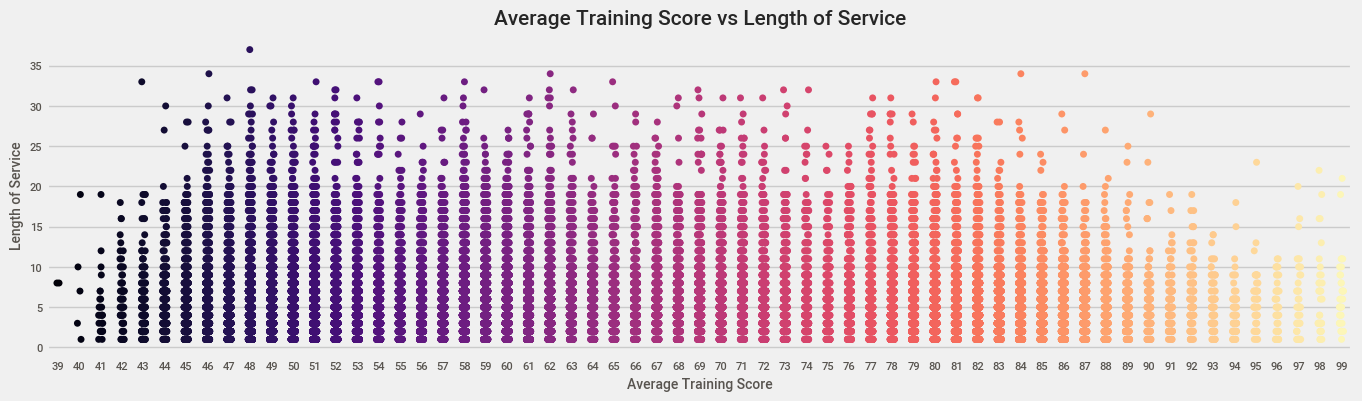

In [35]:
# lets check the relation between the length of service and the average training score

plt.rcParams['figure.figsize'] = (15,4)
sns.stripplot(train['avg_training_score'], train['length_of_service'], palette = 'magma')
plt.title('Average Training Score vs Length of Service', fontsize = 15)
plt.xlabel('Average Training Score', fontsize = 10)
plt.ylabel('Length of Service', fontsize = 10)
plt.xticks(fontsize = 8)
plt.show()

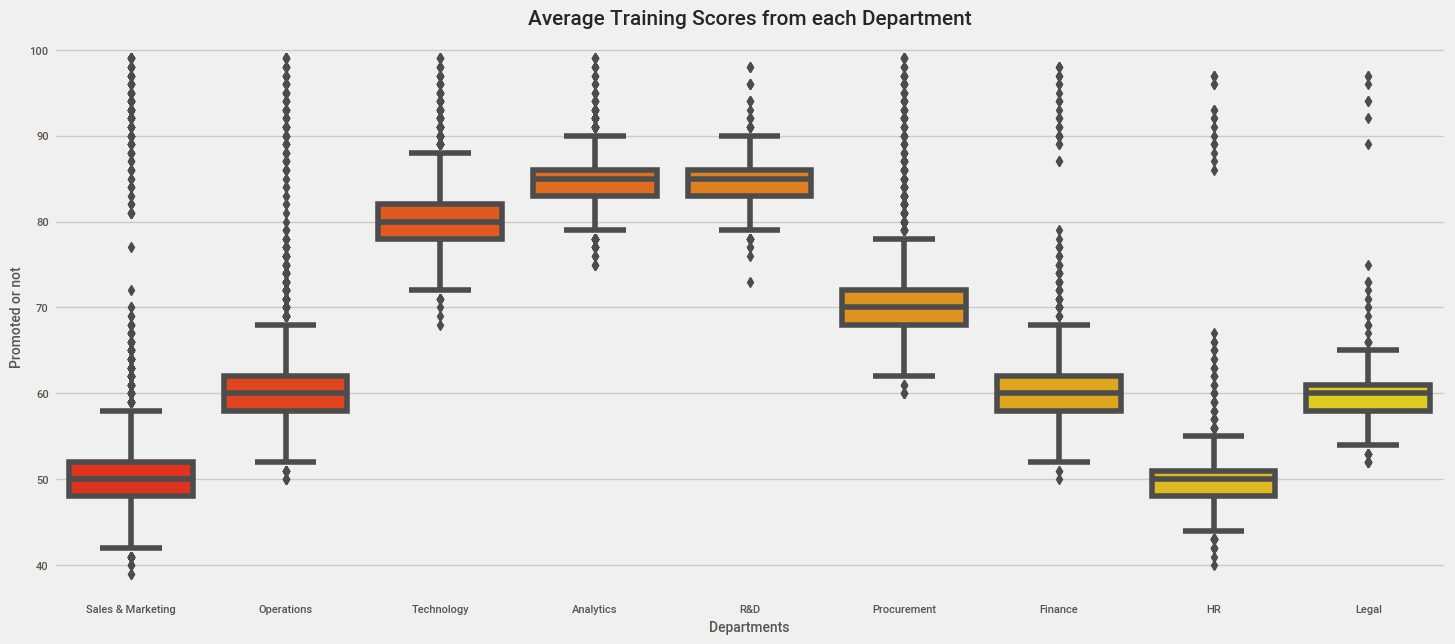

In [36]:
# Department Vs Average Training Score

plt.rcParams['figure.figsize'] = (16, 7)
sns.boxplot(train['department'], train['avg_training_score'], palette = 'autumn')
plt.title('Average Training Scores from each Department', fontsize = 15)
plt.ylabel('Promoted or not', fontsize = 10)
plt.xlabel('Departments', fontsize = 10)
plt.show()

In [37]:
# lets make an Interactive Function for Bivariate Analysis

plt.rcParams['figure.figsize'] = (15, 4)
@interact_manual
def bivariate_plot(column1 = list(train.select_dtypes('object').columns),
                   column2 = list(train.select_dtypes('number').columns[1:])):
    sns.boxplot(train[column1], train[column2])

interactive(children=(Dropdown(description='column1', options=('department', 'region', 'education', 'gender', …

In [38]:
# lets make an Interactive Function for Bivariate Analysis

plt.rcParams['figure.figsize'] = (15, 4)
@interact_manual
def bivariate_plot(column1 = list(train.select_dtypes('object').columns),
                   column2 = list(train.select_dtypes('number').columns[1:])):
    sns.boxenplot(train[column1], train[column2])

interactive(children=(Dropdown(description='column1', options=('department', 'region', 'education', 'gender', …

## Multivariate analysis

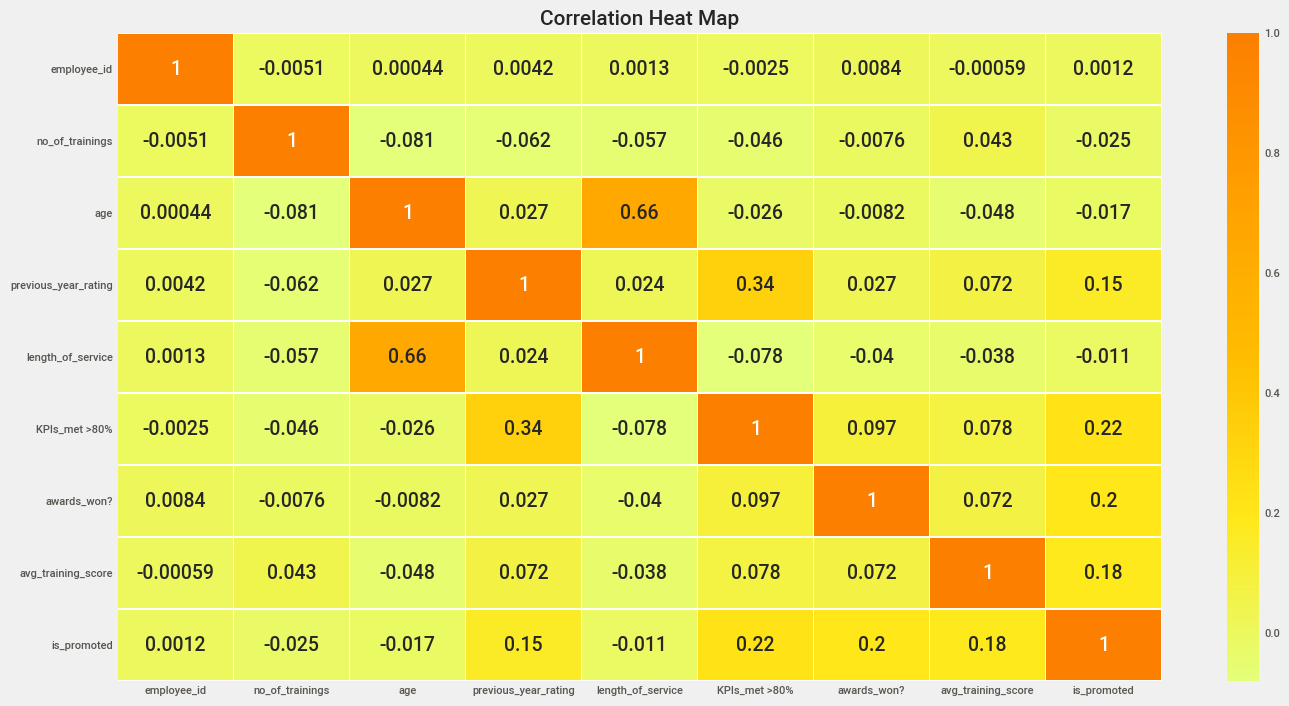

In [39]:
# lets check the Heat Map for the Data with respect to correlation.

plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(train.corr(), annot = True, linewidth = 0.5, cmap = 'Wistia')
plt.title('Correlation Heat Map', fontsize = 15)
plt.show()

In [40]:
# lets use ppscore which is known to be much better

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 10)
sns.heatmap(pps.matrix(train), annot = True, linewidth = 0.5, cmap = 'Reds', fmt = '.0g')
plt.title('Predictive Power Score', fontsize = 15)
plt.show()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

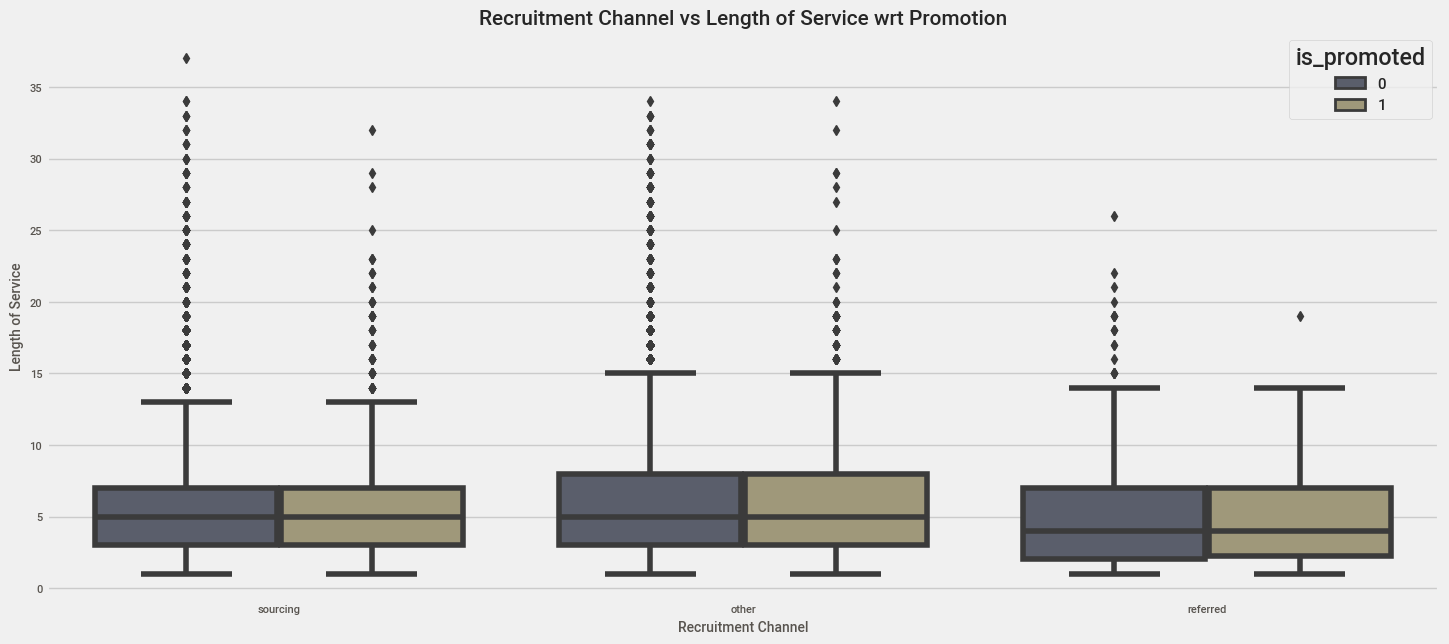

In [42]:
# lets check the relation of Recruitment Channel, length of service and Promotions when they won awards ?

plt.rcParams['figure.figsize'] = (16, 7)
sns.boxplot(train['recruitment_channel'],
            train['length_of_service'],
            hue = train['is_promoted'],
            palette = 'cividis')
plt.title('Recruitment Channel vs Length of Service wrt Promotion', fontsize = 15)
plt.ylabel('Length of Service', fontsize = 10)
plt.xlabel('Recruitment Channel', fontsize = 10)
plt.show()

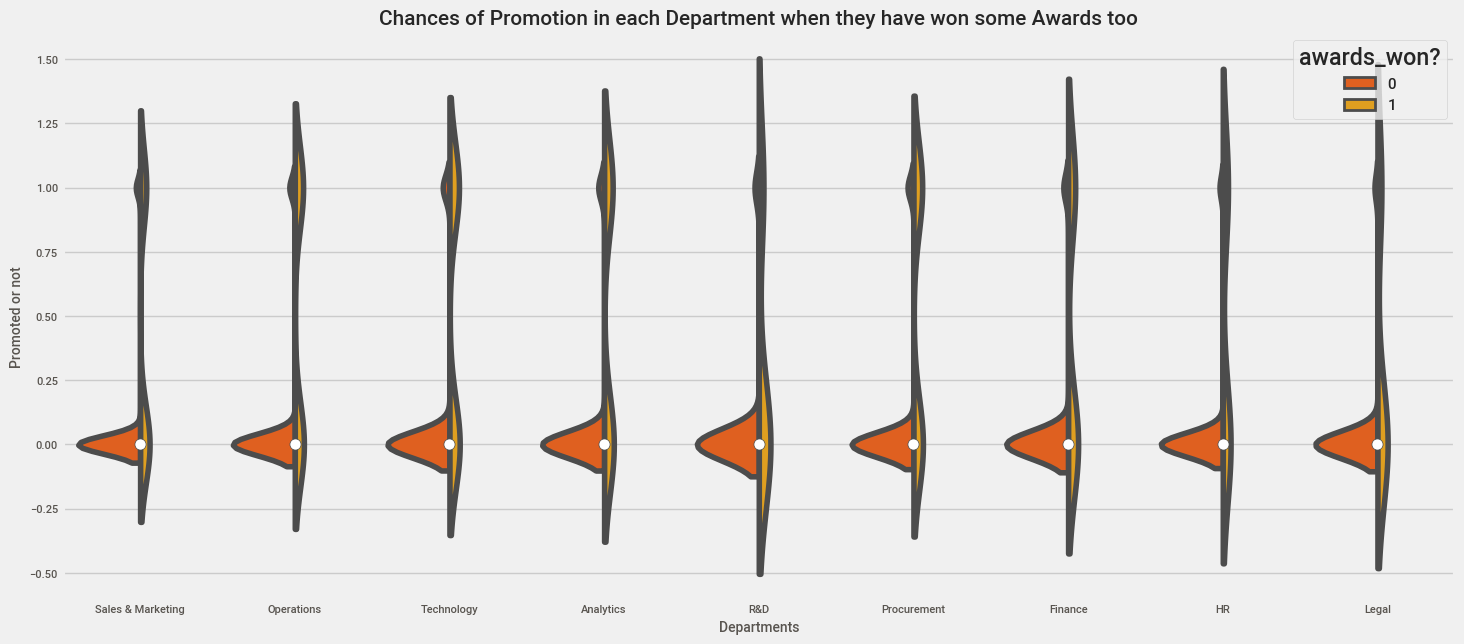

In [43]:
# lets check the relation of Departments and Promotions when they won awards ?

plt.rcParams['figure.figsize'] = (16, 7)
sns.violinplot(train['department'], train['is_promoted'], hue = train['awards_won?'], split = True, palette = 'autumn')
plt.title('Chances of Promotion in each Department when they have won some Awards too', fontsize = 15)
plt.ylabel('Promoted or not', fontsize = 10)
plt.xlabel('Departments', fontsize = 10)
plt.show()

## Feature Engineering

In [44]:
# lets create some extra features from existing features to improve our Model

# creating a Metric of Sum
train['sum_metric'] = train['awards_won?']+train['KPIs_met >80%'] + train['previous_year_rating']
test['sum_metric'] = test['awards_won?']+test['KPIs_met >80%'] + test['previous_year_rating']

# creating a total score column
train['total_score'] = train['avg_training_score'] * train['no_of_trainings']
test['total_score'] = test['avg_training_score'] * test['no_of_trainings']

In [45]:
# lets remove some of the columns which are not very useful for predicting the promotion.

# we already know that the recruitment ch annel is very least related to promotion of an employee, so lets remove this column
# even the region seems to contribute very less, when it comes to promotion, so lets remove it too.
# also the employee id is not useful so lets remove it.

train = train.drop(['recruitment_channel', 'region', 'employee_id'], axis = 1)
test = test.drop(['recruitment_channel', 'region', 'employee_id'], axis = 1)

# lets check the columns in train and test data set after feature engineering
train.columns

Index(['department', 'education', 'gender', 'no_of_trainings', 'age',
       'previous_year_rating', 'length_of_service', 'KPIs_met >80%',
       'awards_won?', 'avg_training_score', 'is_promoted', 'sum_metric',
       'total_score'],
      dtype='object')

## Grouping and Filtering Operations

In [46]:
## lets check the relation between KPIs Met and Promotion

x = pd.crosstab(train['KPIs_met >80%'], train['is_promoted'])
x.style.background_gradient(cmap = 'bone')

is_promoted,0,1
KPIs_met >80%,,
0,34111,1406
1,16029,3262


In [47]:
## lets check the relation between the Awards and Promotion

x = pd.crosstab(train['awards_won?'], train['is_promoted'])
x.style.background_gradient(cmap = 'Blues')

is_promoted,0,1
awards_won?,,
0,49429,4109
1,711,559


In [48]:
# lets check the no. eployees who won awards from each Department

train[['department', 'awards_won?']].groupby(['department']).agg('sum').sort_values(by = 'awards_won?',
                                                            ascending = False).style.background_gradient('magma')

,awards_won?
department,
Sales & Marketing,361
Operations,262
Technology,185
Procurement,171
Analytics,130
Finance,70
HR,45
Legal,25
R&D,21


In [49]:
# lets group the employees based on their Education

@interact
def group(column = list(train.select_dtypes('object').columns)):
    return train[[column, 'is_promoted']].groupby([column]).agg(['count',
                                                'sum', 'mean','min','max']).style.background_gradient(cmap = 'viridis')

interactive(children=(Dropdown(description='column', options=('department', 'education', 'gender'), value='dep…

In [50]:
## lets use the interactive function to make it more reusable

@interact
def group_operations(column = list(train.select_dtypes('object').columns),
                     column2 = list(train.select_dtypes('number').columns)[1:]):
    return train[[column, column2]].groupby([column]).agg('count').style.background_gradient(cmap = 'Wistia')

interactive(children=(Dropdown(description='column', options=('department', 'education', 'gender'), value='dep…

In [51]:
# lets get the names of all the employees who have taken trainings more than 7 Times

@interact
def check(column = 'no_of_trainings', x = 5):
    y = train[train['no_of_trainings'] > x]
    return y['is_promoted'].value_counts()

interactive(children=(Text(value='no_of_trainings', description='column'), IntSlider(value=5, description='x',…

In [52]:
# lets also check the value counts of the number of trainings employee took.
train['no_of_trainings'].value_counts()

1     44378
2      7987
3      1776
4       468
5       128
6        44
7        12
10        5
9         5
8         5
Name: no_of_trainings, dtype: int64

In [53]:
# lets cap the values of number of trainings after 5, as the chances of promotion is negligible after 5th training 

train['no_of_trainings'] = train['no_of_trainings'].replace((6, 7, 8, 9, 10),(5, 5, 5, 5, 5))

# lets check the values of no. of trainings after capping the values
train['no_of_trainings'].value_counts()

1    44378
2     7987
3     1776
4      468
5      199
Name: no_of_trainings, dtype: int64

In [54]:
'''
lets check the no. of employee who did not get an award, did not acheive 80+ KPI, previous_year_rating as 1
and avg_training score is less than 40
but, still got promotion.
''' 

train[(train['KPIs_met >80%'] == 0) & (train['previous_year_rating'] == 1.0) & 
      (train['awards_won?'] == 0) & (train['avg_training_score'] < 60) & (train['is_promoted'] == 1)]

,department,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,sum_metric,total_score
31860,Sales & Marketing,Bachelor's,m,1,27,1.0,2,0,0,58,1,1.0,58
51374,Sales & Marketing,Bachelor's,m,1,31,1.0,5,0,0,58,1,1.0,58


In [55]:
# lets remove the above two columns as they have a huge negative effect on our training data

# lets check shape of the train data before deleting two rows
print("Before Deleting the above two rows :", train.shape)

train = train.drop(train[(train['KPIs_met >80%'] == 0) & (train['previous_year_rating'] == 1.0) & 
      (train['awards_won?'] == 0) & (train['avg_training_score'] < 60) & (train['is_promoted'] == 1)].index)

# lets check the shape of the train data after deleting the two rows
print("After Deletion of the above two rows :", train.shape)

Before Deleting the above two rows : (54808, 13)
After Deletion of the above two rows : (54806, 13)


In [56]:
# lets check how many of the employees have greater than 30 years of service and still do not get promotion

@interact
def check_promotion(x = 20):
    x = train[(train['length_of_service'] > x)]
    return x['is_promoted'].value_counts()
   

interactive(children=(IntSlider(value=20, description='x', max=60, min=-20), Output()), _dom_classes=('widget-…

## Dealing with Categorical Columns

In [57]:
## Lets check the categorical columns present in the data
train.select_dtypes('object').head()

,department,education,gender
0,Sales & Marketing,Master's & above,f
1,Operations,Bachelor's,m
2,Sales & Marketing,Bachelor's,m
3,Sales & Marketing,Bachelor's,m
4,Technology,Bachelor's,m


In [58]:
# lets check the value counts for the education column
train['education'].value_counts()

Bachelor's          39076
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

In [59]:
# lets start encoding these categorical columns to convert them into numerical columns

# lets encode the education in their degree of importance 
train['education'] = train['education'].replace(("Master's & above", "Bachelor's", "Below Secondary"),
                                                (3, 2, 1))
test['education'] = test['education'].replace(("Master's & above", "Bachelor's", "Below Secondary"),
                                                (3, 2, 1))

# lets use Label Encoding for Gender and Department to convert them into Numerical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['department'] = le.fit_transform(train['department'])
test['department'] = le.fit_transform(test['department'])
train['gender'] = le.fit_transform(train['gender'])
test['gender'] = le.fit_transform(test['gender'])

# lets check whether we still have any categorical columns left after encoding
print(train.select_dtypes('object').columns)
print(test.select_dtypes('object').columns)

Index([], dtype='object')
Index([], dtype='object')


In [60]:
# lets check the data after encoding
train.head(3)

,department,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,sum_metric,total_score
0,7,3,0,1,35,5.0,8,1,0,49,0,6.0,49
1,4,2,1,1,30,5.0,4,0,0,60,0,5.0,60
2,7,2,1,1,34,3.0,7,0,0,50,0,3.0,50


## defining y ie target variable

In [61]:
# lets split the target data from the train data
# This is one of the most Important step to perform Machine Learning Prediction on a Dataset, We have to separate the Target and Independent Columns.

# We store the Target Variable in y, and then we store the rest of the columns in x, by deleting the target column from the data
# Also, we are changing the name of test dataset to x_test for ease of understanding.

y = train['is_promoted']
x = train.drop(['is_promoted'], axis = 1)
x_test = test 

# lets print the shapes of these newly formed data sets
print("Shape of the x :", x.shape)
print("Shape of the y :", y.shape)
print("Shape of the x Test :", x_test.shape)

Shape of the x : (54806, 12)
Shape of the y : (54806,)
Shape of the x Test : (23490, 12)


## Resampling

In [62]:
# It is very important to resample the data, as the Target class is Highly imbalanced.
# Here We are going to use Over Sampling Technique to resample the data.
# lets import the SMOTE algorithm to do the same.

from imblearn.over_sampling import SMOTE

x_resample, y_resample  = SMOTE().fit_sample(x, y.values.ravel())

# lets print the shape of x and y after resampling it
print(x_resample.shape)
print(y_resample.shape)

(100280, 12)
(100280,)


In [63]:
# lets also check the value counts of our target variable4

print("Before Resampling :")
print(y.value_counts())

print("After Resampling :")
y_resample = pd.DataFrame(y_resample)
print(y_resample[0].value_counts())

Before Resampling :
0    50140
1     4666
Name: is_promoted, dtype: int64
After Resampling :
1    50140
0    50140
Name: 0, dtype: int64


In [64]:
# lets create a validation set from the training data so that we can check whether the model that we have created is good enough
# lets import the train_test_split library from sklearn to do that

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_resample, y_resample, test_size = 0.2, random_state = 0)

# lets print the shapes again 
print("Shape of the x Train :", x_train.shape)
print("Shape of the y Train :", y_train.shape)
print("Shape of the x Valid :", x_valid.shape)
print("Shape of the y Valid :", y_valid.shape)
print("Shape of the x Test :", x_test.shape)

Shape of the x Train : (80224, 12)
Shape of the y Train : (80224, 1)
Shape of the x Valid : (20056, 12)
Shape of the y Valid : (20056, 1)
Shape of the x Test : (23490, 12)


## Feature Scaling

In [65]:
# It is very import to scale all the features of the dataset into the same scale
# Here, we are going to use the standardization method, which is very commonly used.

# lets import the standard scaler library from sklearn to do that
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)

## Machine Learning Predictive Modelling

Training Accuracy : 0.9903644794575189
Testing Accuracy : 0.9345831671320303


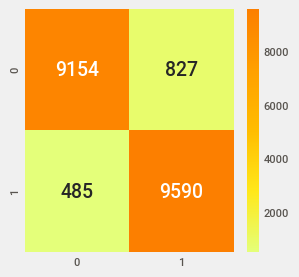

In [66]:
# Lets use Logistic Regression to classify the data
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

model = DecisionTreeClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Testing Accuracy :", model.score(x_valid, y_valid))

cm = confusion_matrix(y_valid, y_pred)
plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(cm, annot = True, cmap = 'Wistia', fmt = '.8g')
plt.show()

## Feature Selection for Decision Tree Model

In [67]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
model = DecisionTreeClassifier() 
rfecv = RFECV(estimator = model, step = 1, cv = 5, scoring = 'accuracy')
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
x_train = pd.DataFrame(x_train)
print('Best features :', x_train.columns[rfecv.support_])

Optimal number of features : 11
Best features : Int64Index([0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')


In [68]:
# lets take a look at the Classification Report

cr = classification_report(y_valid, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      9981
           1       0.92      0.95      0.94     10075

    accuracy                           0.93     20056
   macro avg       0.94      0.93      0.93     20056
weighted avg       0.94      0.93      0.93     20056



## Real time prediction

In [69]:
train.describe()

,department,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,sum_metric,total_score
count,54806.000000,54806.000000,54806.000000,54806.000000,54806.000000,54806.000000,54806.000000,54806.000000,54806.000000,54806.000000,54806.000000,54806.000000,54806.000000
mean,4.972722,2.257636,0.702368,1.250684,34.804127,3.304565,5.865599,0.351987,0.023173,63.386947,0.085137,3.679725,79.771430
std,2.506061,0.469723,0.457221,0.589462,7.660219,1.214712,4.265138,0.477594,0.150453,13.371764,0.279088,1.463326,43.879739
min,0.000000,1.000000,0.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000,1.000000,39.000000
25%,4.000000,2.000000,0.000000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000,3.000000,53.000000
50%,5.000000,2.000000,1.000000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000,4.000000,64.000000
75%,7.000000,3.000000,1.000000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000,5.000000,84.000000
max,8.000000,3.000000,1.000000,5.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000,7.000000,710.000000
